# Train and Test a Logistic Regression Model

In [2]:
#install libraries
!pip install --upgrade pip

!pip install --upgrade scikit-learn

!pip install seaborn
!pip install pandas

     |████████████████████████████████| 1.5 MB 775 kB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.2.4
    Uninstalling pip-20.2.4:
      Successfully uninstalled pip-20.2.4
     |████████████████████████████████| 22.2 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 25.9 MB 326 kB/s eta 0:00:01
     |████████████████████████████████| 303 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 285 kB 776 kB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 970 kB/s eta 0:00:01
     |████████████████████████████████| 510 kB 1.3 MB/s eta 0:00:01


In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.metrics import auc, plot_confusion_matrix, plot_roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import  LogisticRegression


import seaborn as sns
import matplotlib.pyplot as plt

with open('numeric_columns.pickle', 'rb') as f:  
    nu_cols = pickle.load(f)

# Calculate optimal hyperparameters using grid search cross validation on one set of the complete data 
- 5-fold cross validation
- use only the training set (keep the test set separate until after the final model has been built)


scaled shape train (804890, 294)
Fitting 5 folds for each of 90 candidates, totalling 450 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.24826919        nan        nan 0.24826919        nan
        nan 0.24826919        nan        nan 0.24879302        nan
        nan 0.24879302        nan        nan 0.24879302        nan
        nan 0.24897165        nan        nan 0.24897165        nan
        nan 0.24897165        nan        nan 0.24900071        nan
        nan 0.24900962        nan        nan 0.24900962        nan
        nan 0.24899043        nan        nan 0.24896443        nan
        nan 0.24896443        nan        nan 0.24899133        nan
        nan 0.248944          nan        nan 0.248944          nan
        nan 0.24900304        nan        nan 0.24896451        nan
        nan 0.24896451        nan        nan 0.24898786        nan
        nan 0.24894945        nan        nan 0.24894945        nan
        nan 0.24899886        nan        nan 0.24896506  

ROC AUC on training data: 0.8102466621033131
best params /n 
{'C': 0.1, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2'}
best score /n
0.24900961973944008


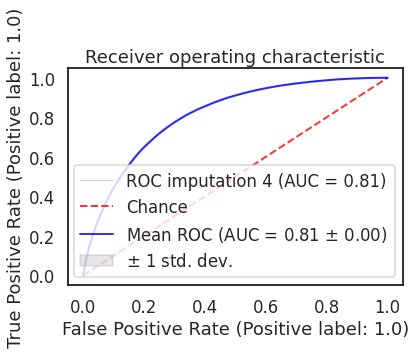

In [116]:
# fix random seed for reproducibility
seed = 78
np.random.seed(seed)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig1, ax1 = plt.subplots()

imp = 5
with open('complete' + str(imp) + '.pickle', 'rb') as f:
        dataset = pickle.load(f)
    #dataset = dataset.iloc[0:100,:]
X_train =  dataset[dataset.subset <= 6].copy().sort_values(by = 'usrds_id')
del dataset
    
y_train = np.array(X_train.pop('died_in_90'))
    
scaler = StandardScaler()
X_train[nu_cols] = scaler.fit_transform(X_train[nu_cols])
X_train = np.array(X_train.drop(columns=['subset','usrds_id','impnum'])) 
print('scaled shape train ' + str(X_train.shape))
    
lr_model = LogisticRegression()
param_grid = [{
        'penalty':['l1','l2','elasticnet'],
        'C': np.logspace(-3, 3, 10, 20),
        'max_iter': [500, 1000, 1500],
        'class_weight' :['balanced'],
        #'solver':['saga']
    }]
    
clf = GridSearchCV(
    lr_model, 
    param_grid=param_grid,
    cv=5,
    verbose=True, 
    n_jobs=-1, 
    scoring='average_precision'
)

best_clf = clf.fit(X_train, y_train)

# save model
with open('2021_LR_cv_clf_imp_'+str(imp)+'.pickle', 'wb') as picklefile:  
        pickle.dump(clf,picklefile)
    
pred_proba_onc_train = clf.predict_proba(X_train)[:,1]
train_score = roc_auc_score(y_train, pred_proba_onc_train)
    
viz = plot_roc_curve(clf, X_train, y_train,
                         name='ROC imputation {}'.format(i),
                         alpha=0.3, lw=1, ax=ax1)
interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
interp_tpr[0] = 0.0
tprs.append(interp_tpr)
aucs.append(viz.roc_auc)

print("ROC AUC on training data: {}".format(train_score))
print('best params /n ' )
print(clf.best_params_)
print('best score /n' )
print(clf.best_score_)


ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax1.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax1.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax1.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax1.legend(loc="lower right")
plt.show()

# Train and Test an LR model
- based on the best params from the previous step
- run the model for each of the 5 imputed datasets
- save the model 
- plot figures

In [118]:
with open('2021_LR_cv_clf_imp_5.pickle', 'rb') as f:  
    clf = pickle.load(f)

clf.best_params_

{'C': 0.1, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2'}

scaled shape train (804890, 294)
scaled shape test (345305, 294)
AVG precision on test data: 0.8103805187674781


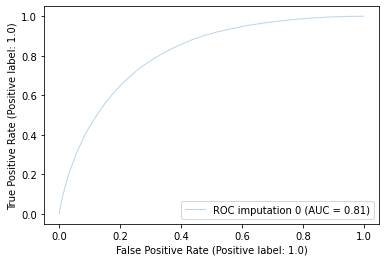

<Figure size 576x576 with 0 Axes>

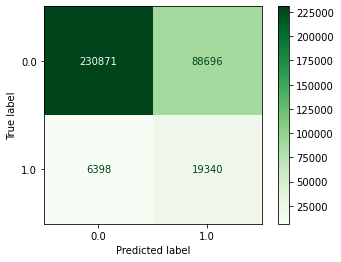

scaled shape train (804890, 294)
scaled shape test (345305, 294)
AVG precision on test data: 0.8103795564592549


<Figure size 576x576 with 0 Axes>

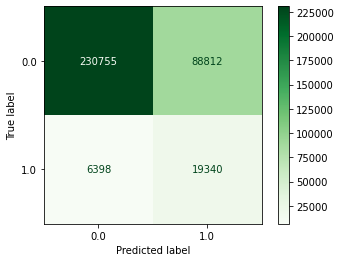

scaled shape train (804890, 294)
scaled shape test (345305, 294)
AVG precision on test data: 0.8106581173951026


<Figure size 576x576 with 0 Axes>

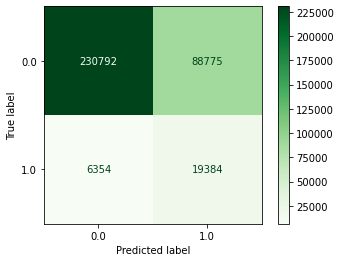

scaled shape train (804890, 294)
scaled shape test (345305, 294)
AVG precision on test data: 0.8104609609264435


<Figure size 576x576 with 0 Axes>

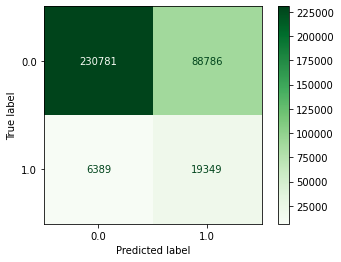

scaled shape train (804890, 294)
scaled shape test (345305, 294)
AVG precision on test data: 0.8102717744124222


<Figure size 576x576 with 0 Axes>

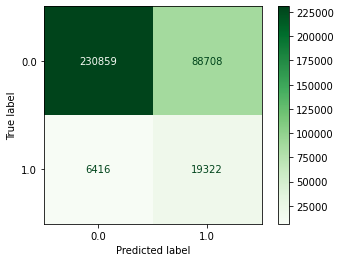

In [12]:
seed = 78
np.random.seed(seed)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()

i=0
for i in range(5):
    imp=i+1

    with open('./complete' + str(imp) + '.pickle', 'rb') as f:
        dataset = pickle.load(f)
    train_x =  dataset[dataset.subset <= 6].copy().sort_values(by = 'usrds_id')
    test_x = dataset[dataset.subset > 6].copy().sort_values(by = 'usrds_id')
    del dataset
    
    train_y = np.array(train_x.pop('died_in_90'))
    test_y = np.array(test_x.pop('died_in_90'))

    
    scaler = StandardScaler()
    train_x[nu_cols] = scaler.fit_transform(train_x[nu_cols])
    train_x = np.array(train_x.drop(columns=['subset','usrds_id','impnum'])) 
    print('scaled shape train ' + str(train_x.shape))
    
    test_x[nu_cols] = scaler.transform(test_x[nu_cols])
    test_x = np.array(test_x.drop(columns=['subset','usrds_id','impnum'])) 
    print('scaled shape test ' + str(test_x.shape))
    
    lr_model_final = LogisticRegression(C=0.1, 
                                              penalty='l2', 
                                             max_iter=1000, 
                                              solver='saga', 
                                              class_weight='balanced',
                                              n_jobs=-1,
                                              verbose=1,
                                             random_state=499)
    
    logistic_model_final = lr_model_final.fit(train_x, train_y)

    # model evaluation

    pred_proba_onc_test = logistic_model_final.predict_proba(test_x)#[:,1]
    
    #save the predictions from each imputation
    with open('2021_final_LR_model_test_pred_proba_imp_' + str(imp) + '.pickle', 'wb') as picklefile:  
        pickle.dump(pred_proba_onc_test, picklefile)
    
    test_score = roc_auc_score(test_y, pred_proba_onc_test[:,1])

    print("AVG precision on test data: {}".format(test_score))
 
    LR_Y_pred = logistic_model_final.predict(test_x)
    
    fig3 = plt.figure(figsize=(8, 8));
    plot_cm = plot_confusion_matrix(
                    logistic_model_final, test_x, test_y,
                    cmap=plt.cm.Greens);
    plt.show()

        
with open('2021_final_LR_model.pickle', 'wb') as picklefile:  
        pickle.dump(logistic_model_final,picklefile)